------
In this iPython notebook is divided into four parts:

- Part 1: Features Selection (Correlation Plot, Random Forest Feature Importance)
- Part 2: Models Tuning (Random Forest, Support Vector Machine, kNN)
- Part 3: Choosing the best model based on ROC curves and Accuracy Rates
- Part 4: Invistaging the best model mis-classification erros


-----
Instructions to run:
- Place the CSV Files in the same directory as the iPython notebook
- Make sure you have the following dependecies: sklearn, matplotlib, numpy, pandas



In [2]:
#Importing libraries
import os
import pandas as pd
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier as random_forest
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold
%matplotlib inline

In [3]:
#Setting the seed for consistent results across different Python runs, and to ensure consistency between R and Python
np.random.seed(100)

In [32]:
# Importing Data
# Contains the extracted fiji features 
df_ = pd.read_csv("All_Features.csv")
# Contains the embryo labels for every super_pixel
df_el = pd.read_csv('embryo_labels.csv')

#reading the spatial data
spatial_train = pd.read_csv('spatial_train.csv')
spatial_test = pd.read_csv('spatial_test.csv')


In [33]:
# Spliting the data into train, test
n_cols = len(spatial_train.columns)-1
#Get the spatial training data (features and labels)
X_train = spatial_train.ix[:,range(n_cols)]
y_train = spatial_train.ix[:,-1]
#Get the testing training data (features and labels)
X_test = spatial_test.ix[:,range(n_cols)]
y_true = spatial_test.ix[:,-1]


df_train = df_[0:28758]
df_test = df_[28758:]

#add the x, y and the distance features to the train and test, data frames
df_train['x'] = X_train.x
df_train['y'] = X_train.y
df_train['distance'] = X_train.distance
df_test.index = range(len(df_test))
df_test['x'] = X_test.x
df_test['y'] = X_test.y
df_test['distance'] = X_test.distance

/Users/fadikfoury/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/fadikfoury/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/fadikfoury/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: h

In [47]:
#labels

df_test['embryo_id'] = df_el.ix[28758:,'embryo_id'].tolist()

/Users/fadikfoury/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [34]:
#Sanity Check
print 'We have ' + str(len(X_train)) + ' training observations'
print 'We have ' + str(len(X_test)) + ' testing observations'

We have 28758 training observations
We have 3906 testing observations


### Defining a boundary measure
Before we proceed with our analysis, we would like to compute a measure for every super pixel that would be representative of the relative location of the super-pixel within an embryo.

    For example, we would like the measure to be near zero, for super pixels near the boundaries
    and we would like the measure to be near 1, for inner super pixels

-------------

We propose a nearset neighbor approach where the weight is given by:

$$w = \frac{same Class NN}{Total NN}$$

In [64]:
"""
This basically predicts the purity of the pixel neighbhours
For every pixel, if all of its neighbohrs had the same label
then the weight would be one
this is done that way to accomodate the fact that at the boundaries 
the trust in the measurement is not that accurate
This will be used later to asses the fit of the best model
"""

#Prep the grouping by embryo
#len(df_test['Unnamed: 0'].map(lambda x: x/1000).unique())
#df_test['embryo_id'] = df_test['Unnamed: 0'].map(lambda x: x/1000)
grouped_by_embryo = df_test.groupby('embryo_id')
df_test['label'] = y_true

        
##Initialize the weights 
df_test['weight'] = np.zeros(len(df_test))+2


#For every embryoo define a knn to use for weighting
for embryo_id, group in grouped_by_embryo:
    X = group.ix[:,['x','y']]
    y = group.ix[:,'label']
    if (len(group) < 5):
        continue
        
    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(X, y) 
    
    print embryo_id
    #print group
    for s_pixel_i in range(len(group)):
        s_pixel = group.iloc[s_pixel_i,:]
        grand_index =  group.index[s_pixel_i]
        #print(neigh.predict([s_pixel['x'],s_pixel['y']]))
        #print neigh.classes_
        #print "PROB"
        if (len(neigh.predict_proba([s_pixel['x'],s_pixel['y']])[0])<3):
            print neigh.predict_proba([s_pixel['x'],s_pixel['y']])[0]
        W_i = neigh.predict_proba([s_pixel['x'],s_pixel['y']])[0][ np.where( neigh.classes_ == s_pixel['label'] )[0][0]]
        
        df_test.loc[grand_index,'weight'] =  W_i
        #if s_pixel_i>10:
        #    break        
w_test_set = df_test['weight']



113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
135
136
139
143
148
150
151
152
157
161
164
[ 0.8  0.2]
[ 0.8  0.2]
[ 0.8  0.2]
[ 0.8  0.2]
[ 0.8  0.2]
[ 0.8  0.2]
170


/Users/fadikfoury/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/fadikfoury/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Part 1: Features Selection

In [9]:
df_train.columns

Index([u'Mean1', u'Mean2', u'Mean3', u'Mean4', u'Mean5', u'Mean6', u'Mean7',
       u'Mean8', u'Mean9', u'Mean10', u'Mean11', u'Mean12', u'Mean13',
       u'Median1', u'Median2', u'Median3', u'Median4', u'Median5', u'Median6',
       u'Median7', u'Median8', u'Median9', u'Median10', u'Median11',
       u'Median12', u'Median13', u'Variance1', u'Variance2', u'Variance3',
       u'Variance4', u'Variance5', u'Variance6', u'Variance7', u'Variance8',
       u'Variance9', u'Variance10', u'Variance11', u'Variance12',
       u'Variance13', u'Skewness1', u'Skewness2', u'Skewness3', u'Skewness4',
       u'Skewness5', u'Skewness6', u'Skewness7', u'Skewness8', u'Skewness9',
       u'Skewness10', u'Skewness11', u'Skewness12', u'Skewness13',
       u'Kurtosis1', u'Kurtosis2', u'Kurtosis3', u'Kurtosis4', u'Kurtosis5',
       u'Kurtosis6', u'Kurtosis7', u'Kurtosis8', u'Kurtosis9', u'Kurtosis10',
       u'Kurtosis11', u'Kurtosis12', u'Kurtosis13', u'x', u'y', u'distance'],
      dtype='object')

In [8]:
del df_train['Unnamed: 0']

In [10]:
df_test.columns

Index([u'Unnamed: 0', u'Mean1', u'Mean2', u'Mean3', u'Mean4', u'Mean5',
       u'Mean6', u'Mean7', u'Mean8', u'Mean9', u'Mean10', u'Mean11', u'Mean12',
       u'Mean13', u'Median1', u'Median2', u'Median3', u'Median4', u'Median5',
       u'Median6', u'Median7', u'Median8', u'Median9', u'Median10',
       u'Median11', u'Median12', u'Median13', u'Variance1', u'Variance2',
       u'Variance3', u'Variance4', u'Variance5', u'Variance6', u'Variance7',
       u'Variance8', u'Variance9', u'Variance10', u'Variance11', u'Variance12',
       u'Variance13', u'Skewness1', u'Skewness2', u'Skewness3', u'Skewness4',
       u'Skewness5', u'Skewness6', u'Skewness7', u'Skewness8', u'Skewness9',
       u'Skewness10', u'Skewness11', u'Skewness12', u'Skewness13',
       u'Kurtosis1', u'Kurtosis2', u'Kurtosis3', u'Kurtosis4', u'Kurtosis5',
       u'Kurtosis6', u'Kurtosis7', u'Kurtosis8', u'Kurtosis9', u'Kurtosis10',
       u'Kurtosis11', u'Kurtosis12', u'Kurtosis13', u'x', u'y', u'distance'],
      dtype='obj

In [11]:
#Delete the extranous fields
#del df_test['label']
#del df_test['weight']
#del df_test['embryo_id']
del df_test['Unnamed: 0']

### Correlation Plot

In [12]:
#Training a random forest on all the data
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

/Users/fadikfoury/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


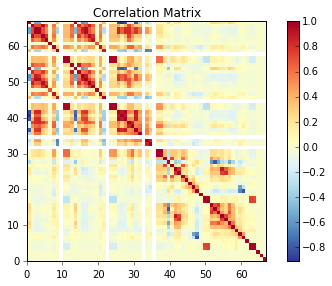

In [13]:
corr_matrix = np.corrcoef(df_train.ix[:,1:70].values.T)
sm.graphics.plot_corr(corr_matrix)
plt.show()

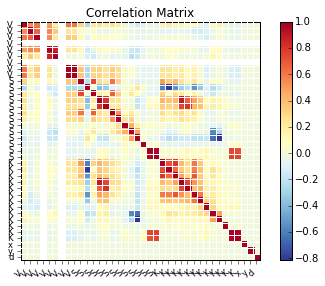

In [14]:
#cutting features at 30, since those above 30 seem to be less correlated
cut_i = 30
b = []
for a in df_train.ix[:,cut_i:].columns:
    b.append(a[0])
corr_matrix = np.corrcoef(df_train.ix[:,cut_i:].values.T)
fig = sm.graphics.plot_corr(corr_matrix,xnames=b)
plt.show()

In [15]:
df_train.columns == df_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True], dtype=bool)

In [22]:
#running Random forest
forest = random_forest(n_estimators = 1000, max_depth=50)
forest.fit(df_train.ix[:,30:], y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Feature ranking:
1. feature 37 (0.344066)distance
2. feature 35 (0.195090)x
3. feature 36 (0.177166)y
4. feature 0 (0.028032)Variance5
5. feature 4 (0.027345)Variance9
6. feature 5 (0.026353)Variance10
7. feature 25 (0.018890)Kurtosis4
8. feature 1 (0.018655)Variance6
9. feature 23 (0.012325)Kurtosis2
10. feature 26 (0.012187)Kurtosis5
11. feature 7 (0.009668)Variance12
12. feature 8 (0.009398)Variance13
13. feature 33 (0.007904)Kurtosis12
14. feature 34 (0.007860)Kurtosis13
15. feature 22 (0.007802)Kurtosis1
16. feature 31 (0.007752)Kurtosis10
17. feature 24 (0.007674)Kurtosis3
18. feature 12 (0.007014)Skewness4
19. feature 32 (0.006822)Kurtosis11
20. feature 13 (0.006073)Skewness5
21. feature 29 (0.005996)Kurtosis8
22. feature 30 (0.005853)Kurtosis9
23. feature 27 (0.005632)Kurtosis6
24. feature 10 (0.005393)Skewness2
25. feature 28 (0.004765)Kurtosis7
26. feature 21 (0.004406)Skewness13
27. feature 20 (0.004401)Skewness12
28. feature 18 (0.004218)Skewness10
29. feature 19 (0.003904)

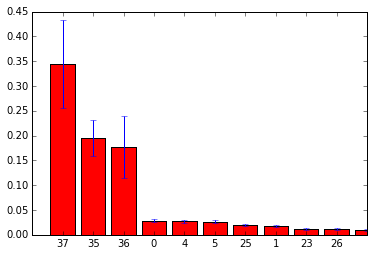

In [23]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(len(df_train.ix[:,30:].columns)):
    print str("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]])) + str(df_train.ix[:,30:].columns[indices[f]])
    

# Plot the feature importances of the forest
plt.figure()
#plt.title("Feature importances")
plt.bar(range(len(df_train.ix[:,30:].columns)), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(10), indices)
plt.xlim([-1, 10])
#plt.xticks(range(len(df_test.columns)), df_test.columns)
plt.show()


In [18]:
#getting rid of redundant features
df_train = df_train.ix[:,30:] #cor plot filter

In [25]:
#Picking the best 20 features as the most important features based on random forest
best_column_features = indices[:20]

In [16]:
best_column_features = [37, 35, 36,  0,  4,  5, 25,  1, 23, 26,  7,  8, 33, 34, 22, 31, 24,
       12, 32, 13]

Plotting the histogram of the classes

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10bc8fd10>]], dtype=object)

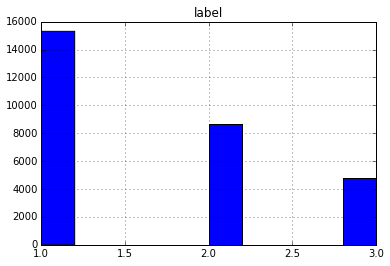

In [17]:
pd.DataFrame(y_train).hist()

# Tuning Models

##Random Forest - Tunning the min samples to split

In [ ]:
# Defining the random forest cross validation function

In [19]:
def getROCandAccuracyOfCLF(forest_i,X,y,ROC=False):
    """
    This function takes the 
    """
    kf = cross_validation.KFold(len(X), n_folds=6,shuffle=True)
    #initialize the cv_labels_np_array

    cv_labels = np.array(range(len(y)))
    cv_score = np.ones((len(y),3))
    acc_array = []
    
    fpr_array = []
    
    tpr_array = []
    
    auc_array = []
    for train_index, test_index in kf:
        #print X.head()
        train_x = X.ix[train_index,:]
        train_y = y[train_index]

        test_x = X.ix[test_index,:]
        test_y = y[test_index]

        #Train the classifier
        #forest_i = random_forest(n_estimators = 1000, max_depth=50, min_samples_split=19, n_jobs =-1 )
        forest_i.fit(train_x, train_y)
        cv_labels = forest_i.predict(test_x)
        
        #Compute the accuracy
        acc_array.append(sum(test_y==cv_labels)/float(len(cv_labels)))
        if(ROC):
            #compute the ROC
            cv_score = forest_i.predict_proba(test_x)

            #TP TN
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            n_classes = forest_i.classes_
            for i in range(3):
                print n_classes[i]
                fpr[i], tpr[i], _ = roc_curve(test_y==n_classes[i], cv_score[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])

            fpr_array.append(fpr)
            tpr_array.append(tpr)

            auc_array.append(roc_auc)
        
    return fpr_array, tpr_array, auc_array, acc_array

In [125]:
forest = random_forest(n_estimators = 500, max_depth=50, min_samples_split = 19, n_jobs =-1)
a,b,c,d = getROCandAccuracyOfCLF(forest, df_train.ix[:,best_column_features], y_train)

In [135]:
ms_acc = []
for min_s in range(2,36,4):
    forest = random_forest(n_estimators = 500, max_depth=50, min_samples_split = min_s, n_jobs =-1)
    a,b,c,d = getROCandAccuracyOfCLF(forest, df_train.ix[:,best_column_features], y_train)
    #Predicting
    a =  np.array(d).mean()
    ms_acc.append([min_s,float(a)])
    print 'iteration:' + str(min_s)

iteration:2
iteration:6
iteration:10
iteration:14
iteration:18
iteration:22
iteration:26
iteration:30
iteration:34


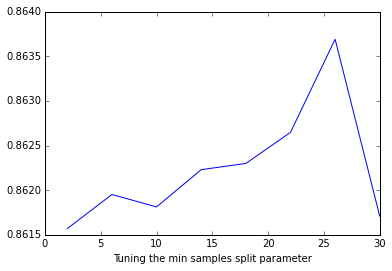

In [141]:
plt.plot(np.array(ms_acc)[:,0],np.array(ms_acc)[:,1])
plt.xlabel('Tuning the min samples split parameter')

# Tuning SVM

In [21]:
def getROCandAccuracyOfCLFSVM(forest_i,X,y,ROC=False):
    """
    This function takes the 
    """
    kf = cross_validation.KFold(len(X), n_folds=6,shuffle=True)
    #initialize the cv_labels_np_array

    cv_labels = np.array(range(len(y)))
    cv_score = np.ones((len(y),3))
    acc_array = []
    
    fpr_array = []
    
    tpr_array = []
    
    auc_array = []
    for train_index, test_index in kf:
        #print X.head()
        train_x = X.ix[train_index,:]
        train_y = y[train_index]

        test_x = X.ix[test_index,:]
        test_y = y[test_index]

        #Train the classifier
        #forest_i = random_forest(n_estimators = 1000, max_depth=50, min_samples_split=19, n_jobs =-1 )
        forest_i.fit(StandardScaler().fit_transform(train_x), train_y)
        cv_labels = forest_i.predict(test_x)
        
        
        
        #Compute the accuracy
        acc_array.append(sum(test_y==cv_labels)/float(len(cv_labels)))
        if(ROC):
            #compute the ROC
            cv_score = forest_i.decision_function(test_x)
            #TP TN
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            n_classes = forest_i.classes_
            for i in range(3):
                print n_classes[i]
                fpr[i], tpr[i], _ = roc_curve(test_y==n_classes[i], cv_score[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])

            fpr_array.append(fpr)
            tpr_array.append(tpr)

            auc_array.append(roc_auc)
        
    return fpr_array, tpr_array, auc_array, acc_array

In [ ]:
msvm_acc = []
for C_i in range(2,50,10):
    svm_ = svm.SVC(C = C_i)
    a,b,c,d = getROCandAccuracyOfCLF(svm_, df_train.ix[:,best_column_features], y_train)
    #Predicting
    a =  np.array(d).mean()
    msvm_acc.append([C_i,float(a)])
    print 'iteration:' + str(C_i)

iteration:2
iteration:12

In [ ]:
plt.plot(np.array(msvm_acc)[:,0],np.array(msvm_acc)[:,1])
plt.xlabel('Tuning the C SVM Parameter')

In [ ]:
#ok so lets pick C = 60 since it seems like a stable peak.

# Plotting the ROC Curves

In [152]:
forest = random_forest(n_estimators = 1000, max_depth=50, min_samples_split = 26, n_jobs =-1)
a,b,c,d = getROCandAccuracyOfCLF(forest, df_train.ix[:,best_column_features], y_train, ROC = True)

1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3


In [224]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = [0,1,2]
for i in range(3):
    print n_classes[i]
    fpr[i]= np.array(pd.DataFrame(pd.DataFrame(a)[i].tolist()).mean().tolist())
    tpr[i]= np.array(pd.DataFrame(pd.DataFrame(b)[i].tolist()).mean().tolist())
    roc_auc[i] = np.array(pd.DataFrame(pd.DataFrame(c)[i].tolist()).mean().tolist())

0
1
2


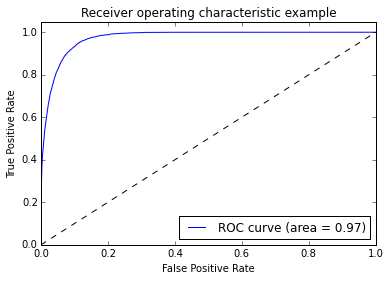

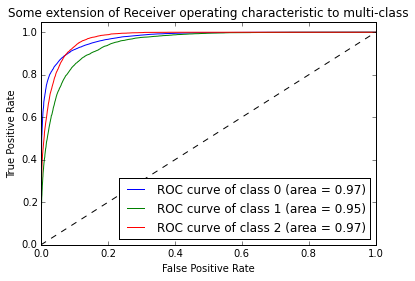

In [229]:
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve
plt.figure()

for i in range(len(n_classes)):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, float(roc_auc[i])))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

## SVM ROC

In [22]:
from sklearn.preprocessing import StandardScaler
svm_ = svm.SVC(C = 60)
a,b,c,d = getROCandAccuracyOfCLFSVM(svm_,  df_train.ix[:,best_column_features], y_train, ROC = True)

1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3


0
1
2


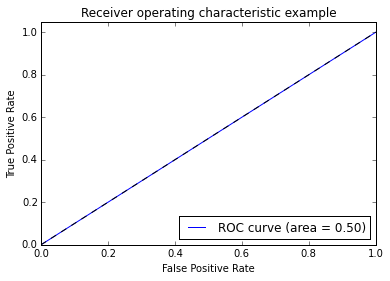

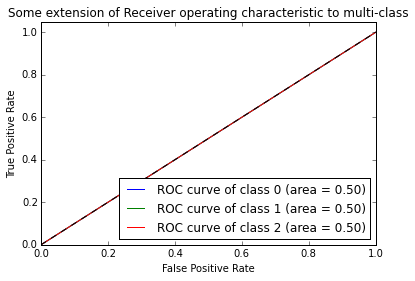

In [24]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = [0,1,2]
for i in range(3):
    print n_classes[i]
    fpr[i]= np.array(pd.DataFrame(pd.DataFrame(a)[i].tolist()).mean().tolist())
    tpr[i]= np.array(pd.DataFrame(pd.DataFrame(b)[i].tolist()).mean().tolist())
    roc_auc[i] = np.array(pd.DataFrame(pd.DataFrame(c)[i].tolist()).mean().tolist())
    
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve
plt.figure()

for i in range(len(n_classes)):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, float(roc_auc[i])))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [29]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=151)
a,b,c,d = getROCandAccuracyOfCLF(neigh, df_train.ix[:,-3:], y_train, ROC = True)
 

1
2
3
1
2
3
1
2
3
1
2
3
1
2
3
1
2
3


In [30]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = [0,1,2]
for i in range(3):
    print n_classes[i]
    fpr[i]= np.array(pd.DataFrame(pd.DataFrame(a)[i].tolist()).mean().tolist())
    tpr[i]= np.array(pd.DataFrame(pd.DataFrame(b)[i].tolist()).mean().tolist())
    roc_auc[i] = np.array(pd.DataFrame(pd.DataFrame(c)[i].tolist()).mean().tolist())

0
1
2


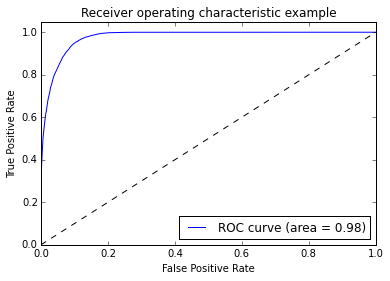

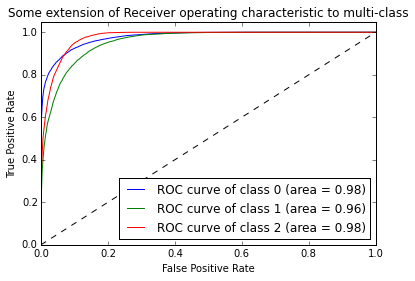

In [31]:
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve
plt.figure()

for i in range(len(n_classes)):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, float(roc_auc[i])))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Evaluating the performace of KNN

In [86]:
neigh = KNeighborsClassifier(n_neighbors=151)
neigh.fit(df_train.ix[:,-3:], y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=151, p=2, weights='uniform')

In [87]:
predictions = neigh.predict(df_test.ix[:,-3:])

In [88]:
sum(predictions==y_true)/float(len(y_true))

0.86610343061955963

In [89]:
#Percentage Match at the boundaries
sum(  (predictions==y_true)*(w_test_set<0.9) )/float(sum((w_test_set<0.9)))

/Users/fadikfoury/anaconda/lib/python2.7/site-packages/pandas/computation/expressions.py:190: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


0.77940503432494279

In [91]:
#Percentage Match at the inner regions
sum((predictions==y_true)*(w_test_set>0.9) )/float(sum((w_test_set>0.9)))

0.97617664148750727